# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [2]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True

if GENERATE:
    print("GENERATE = False, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENERATE = False, so we will generate new samples.


### Running PAC

In [3]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator

In [4]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [5]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
por_df.shape

(649, 33)

In [6]:
por_df['absences'].count()

649

In [7]:
por_df['absences'].agg(['count','sum', 'mean', 'var']).to_numpy()

array([ 649.        , 2375.        ,    3.65947612,   21.53664232])

In [8]:
### Query Setup
SAMPLES = 1024
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

true_result = por_df['absences'].agg(['count','sum', 'mean', 'var']).to_numpy() # Save the true result of the query for later
number_of_contributing_rows = por_df['absences'].count()

def rowwise_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select half of the row indices from the dataframe at random.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = np.random.choice(df.index, size=(df.shape[0] // 2), replace=False)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.iloc[indices]
    not_selected: DataFrame = df.iloc[not_indices]
    return (selected, not_selected)

def run_query(i: int) -> List[np.ndarray]:
    # i is not used for anything, just to satisfy the map function.
    # Returns two results each invocation as a result of paired sampling.
    results = []
    for temp_df in rowwise_paired_sample(por_df):
        out_df = temp_df['absences'].agg(['count','sum', 'mean', 'var'])  # run the query
        out_df['count'] *= 2  # correct query result for the 50% subsampling
        out_df['sum'] *= 2  # correct query result for the 50% subsampling
        results.append(out_df.to_numpy())
    return results

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # thresholding happens here for PAC -- if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)
    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        out_np.append(run_query(i))
    out_np = reduce(operator.iconcat, out_np, [])
    # https://stackoverflow.com/a/45323085

    #with concurrent.futures.ThreadPoolExecutor() as executor:
    #    out_np: List[np.ndarray] = list(executor.map(run_query, range(number_of_pairs)))
    #    out_np = reduce(operator.iconcat, out_np, [])
    #    # https://stackoverflow.com/a/45323085

    return out_np

In [9]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4) -> np.ndarray:

    
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    pac_release = out_np[0] + pac_noises_to_add

    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [10]:
MI_OPTIONS = [16., 4., 2., 1., 1/4, 1/16, 1/32, 1/64]
EXPERIMENTS = 50

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []

    for mi in MI_OPTIONS: 
        for e in range(EXPERIMENTS):
            out_np = generate_samples()
            noisy_output = do_pac_and_release(out_np, mi)
            experiment_results.append([mi, *noisy_output])
        with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
            pickle.dump(experiment_results, f)
    
    df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'sum', 'mean', 'var'])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    # with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    # with open('{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

,mi,count,sum,mean,var
0,16.0,651.664410,2886.780724,2.511821,25.724818
1,16.0,653.418038,2987.510212,2.688667,24.339546
2,16.0,653.656356,1715.427002,3.206028,9.588084
3,16.0,647.594550,2183.729155,3.846939,13.274608
4,16.0,646.821550,2158.898956,3.275665,17.882608


### Computing PAC Errors

In [11]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [12]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[['count', 'sum', 'mean', 'var']].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', 'absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var', 'relative error count', 'relative error sum', 'relative error mean', 'relative error var'])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,absolute error var,relative error count,relative error sum,relative error mean,relative error var
0,16.000000,2.664410,511.780724,1.147655,4.188176,0.410541,21.548662,31.361188,19.446746
1,16.000000,4.418038,612.510212,0.970809,2.802904,0.680745,25.789904,26.528624,13.014582
2,16.000000,4.656356,659.572998,0.453449,11.948558,0.717466,27.771495,12.391077,55.480135
3,16.000000,1.405450,191.270845,0.187463,8.262035,0.216556,8.053509,5.122660,38.362687
4,16.000000,2.178450,216.101044,0.383811,3.654034,0.335663,9.098991,10.488146,16.966592
...,...,...,...,...,...,...,...,...,...
395,0.015625,2187.101160,444736.418745,1114.402628,7857.760833,336.995556,18725.743947,30452.518116,36485.542718
396,0.015625,2160.811329,208173.446334,508.934674,16012.207441,332.944735,8765.197740,13907.309617,74348.671465
397,0.015625,1672.954670,588341.267869,264.803450,19431.283698,257.774217,24772.263910,7236.102684,90224.295002
398,0.015625,1476.873463,508940.974386,1542.056826,3012.119176,227.561397,21429.093658,42138.731782,13986.020344


In [13]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [14]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp-results.parquet").to_pandas()
dp_errors_df = pq.read_table(f"outputs/dp-errors.parquet").to_pandas()

In [31]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")
all_df

count mean     count var      sum mean       sum var  \
type factor                                                             
dp   0.200000           NaN           NaN           NaN           NaN   
     0.360000           NaN           NaN           NaN           NaN   
     0.400000           NaN           NaN           NaN           NaN   
     0.600000     27.012086           NaN -13934.758083           NaN   
     0.730000     29.864554  1.985885e+02  57559.585589  7.859298e+08   
     0.800000     19.424820  1.453099e+01  13444.677449  4.880396e+08   
     1.000000     22.782015  6.716032e+01   1202.635907  7.386599e+08   
     1.200000     23.820611  4.403960e+01   -693.383649  4.179716e+08   
     1.400000     24.176187  3.814077e+01   -638.337825  2.999726e+08   
     1.640000     23.880655  2.872480e+01    495.535567  2.431191e+08   
     1.800000     24.175826  2.394297e+01    129.990515  2.062910e+08   
     2.000000     23.905020  2.085775e+01    673.582050  1.607352e+08   
     3.000000     24.197451  8.793445e+00    225.977380  7.953828e+07   
     4.000000     24.095631  4.879727e+00   -266.678818  4.511043e+07   
     5.000000     24.013572  3.235330e+00    125.159179  3.359931e+07   
     6.000000     24.061226  2.597636e+00    -42.891428  2.361116e+07   
     7.000000     23.955004  1.929674e+00   -145.596364  1.616495e+07   
     8.000000     24.007381  1.485909e+00    -18.169597  1.417874e+07   
     9.000000     24.018235  1.233782e+00   -133.933115  1.086030e+07   
     10.000000    24.007978  1.110470e+00     33.680304  8.728696e+06   
pac  0.015625    716.502489  1.351458e+07  65839.550256  2.407054e+11   
     0.031250   1277.071998  3.201165e+06  18193.692470  6.173399e+10   
     0.062500    780.087936  9.273589e+05   4457.073726  1.547373e+10   
     0.250000    695.478521  5.306679e+04   3938.527888  7.593281e+08   
     1.000000    636.387776  2.651559e+03   1208.923069  5.419841e+07   
     2.000000    652.322526  9.471869e+02   2025.454219  1.236072e+07   
     4.000000    647.542605  2.486144e+02   2511.714295  2.322415e+06   
     16.000000   649.477850  1.150858e+01   2438.216724  2.180802e+05   

                mean mean       mean var      var mean       var var  
type factor                                                           
dp   0.200000         NaN            NaN           NaN           NaN  
     0.360000         NaN            NaN -1.628917e+04           NaN  
     0.400000         NaN            NaN  2.351314e+03           NaN  
     0.600000         NaN            NaN -1.069913e+06           NaN  
     0.730000         NaN            NaN -6.783881e+06  6.648767e+13  
     0.800000         NaN            NaN -1.735833e+06  7.699677e+12  
     1.000000    0.055378            NaN -6.535972e+05  5.304606e+12  
     1.200000   -0.492588      30.881814 -3.789902e+05  1.871961e+12  
     1.400000   -0.717541      34.622510 -2.570506e+05  1.072120e+12  
     1.640000   -0.125412      15.758399 -1.621358e+05  6.486569e+11  
     1.800000    0.456100       5.232873 -1.339149e+05  6.174577e+11  
     2.000000    0.661979       4.683915 -8.537931e+04  1.981710e+11  
     3.000000    0.800454       1.417389 -4.234022e+03  4.941188e+08  
     4.000000    0.875129       0.925919 -7.834372e+02  2.651156e+07  
     5.000000    0.965009       0.541989 -7.378738e+02  1.075401e+07  
     6.000000    1.000395       0.390738 -2.386077e+02  2.787985e+06  
     7.000000    0.977539       0.301863 -1.128724e+02  1.871567e+06  
     8.000000    0.972487       0.230690 -1.670170e+02  1.399925e+06  
     9.000000    0.989088       0.184164 -2.202679e+02  1.323995e+06  
     10.000000   1.007524       0.138744 -8.705227e+01  8.381122e+05  
pac  0.015625  -42.285680  502208.825163  1.199424e+03  6.483583e+07  
     0.031250  -64.525217   94370.883937 -5.243751e+02  2.007965e+07  
     0.062500   -9.504284   34459.935347 -1.500883e+02  4.439779e+06  
     0.250000    5.251542    1664.292862  1.348887e

In [35]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error sum', 'mean'), ('absolute error mean', 'mean'), ('absolute error var', 'mean'), ('relative error count', 'var'), ('relative error sum', 'var'), ('relative error mean', 'var'), ('relative error var', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns
errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error count var  absolute error sum var  \
type factor                                                        
dp   0.200000                        NaN                     NaN   
     0.360000                        NaN                     NaN   
     0.400000                        NaN                     NaN   
     0.600000                        NaN                     NaN   
     0.730000               1.985885e+02            7.859298e+08   
     0.800000               1.453099e+01            2.237735e+08   
     1.000000               6.716032e+01            2.228101e+08   
     1.200000               4.403960e+01            1.571997e+08   
     1.400000               3.814077e+01            1.149796e+08   
     1.640000               2.872480e+01            8.898952e+07   
     1.800000               2.394297e+01            7.903430e+07   
     2.000000               2.085775e+01            6.373527e+07   
     3.000000               8.793445e+00            3.001089e+07   
     4.000000               4.879727e+00            1.958923e+07   
     5.000000               3.235330e+00            1.521497e+07   
     6.000000               2.597636e+00            1.103846e+07   
     7.000000               1.929674e+00            8.083748e+06   
     8.000000               1.485909e+00            6.497140e+06   
     9.000000               1.233782e+00            5.893933e+06   
     10.000000              1.110470e+00            4.627719e+06   
pac  0.015625               5.219171e+06            8.009114e+10   
     0.031250               1.232774e+06            1.661119e+10   
     0.062500               2.936523e+05            4.976842e+09   
     0.250000               1.939019e+04            3.146424e+08   
     1.000000               1.092211e+03            2.489494e+07   
     2.000000               3.594023e+02            3.606303e+06   
     4.000000               9.887255e+01            1.075708e+06   
     16.000000              4.620398e+00            8.541798e+04   

                absolute error mean var  absolute error var var  \
type factor                                                       
dp   0.200000                       NaN                     NaN   
     0.360000                       NaN                     NaN   
     0.400000                       NaN                     NaN   
     0.600000                       NaN                     NaN   
     0.730000                       NaN            6.648767e+13   
     0.800000                       NaN            7.692205e+12   
     1.000000                       NaN            5.300014e+12   
     1.200000                 29.451372            1.868708e+12   
     1.400000                 34.438801            1.068877e+12   
     1.640000                 15.452674            6.475880e+11   
     1.800000                  5.029797            6.166957e+11   
     2.000000                  4.464645            1.977192e+11   
     3.000000                  1.396439            4.771297e+08   
     4.000000                  0.925919            2.208267e+07   
     5.000000                  0.541989            7.895920e+06   
     6.000000                  0.390738            1.233272e+06   
     7.000000                  0.301863            8.467230e+05   
     8.000000                  0.230690            5.969314e+05   
     9.000000                  0.184164            5.757383e+05   
     10.000000                 0.138744            3.609700e+05   
pac  0.015625             162894.261206            3.108949e+07   
     0.031250              36722.329059            7.162838e+06   
     0.062500              11410.341274            1.253243e+06   
     0.250000                528.515108            1.246350e+05   
     1.000000                 45.629113            5.010881e+03   
     2.000000                 11.892745            1.904128e+03   
     4.000000                  3.101328            3.902118e+02   
     16.000000                 0

In [17]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [18]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [19]:
PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# create legend, use color squares
from matplotlib.patches import Patch
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

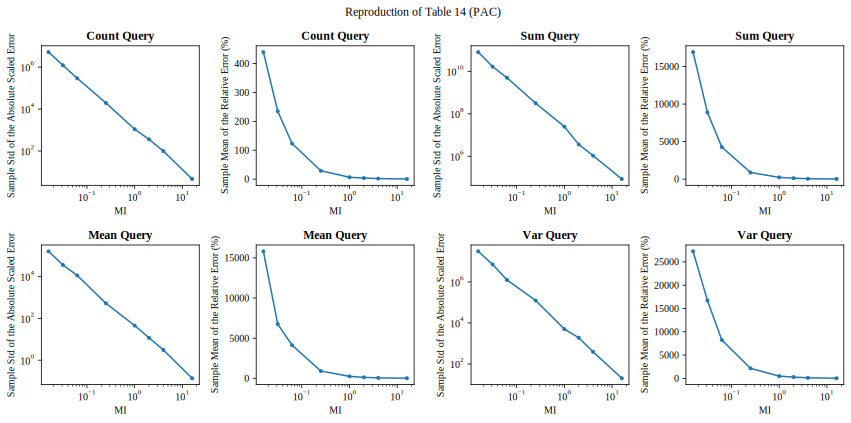

In [37]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

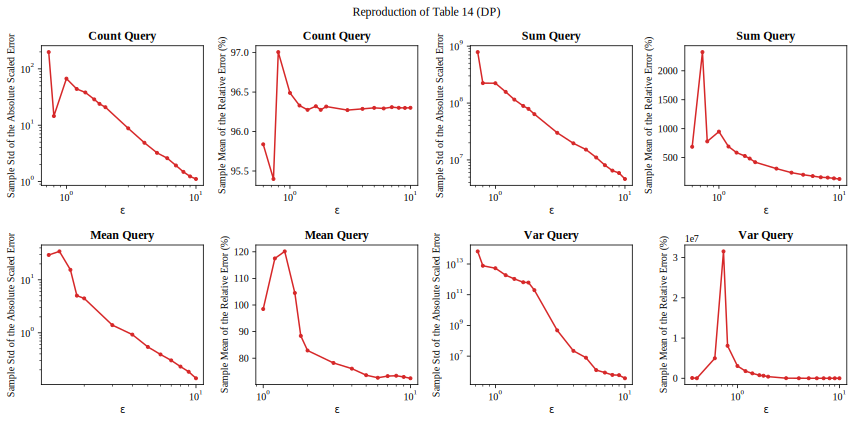

In [38]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

An attempt at putting both on the same axes, not aligned

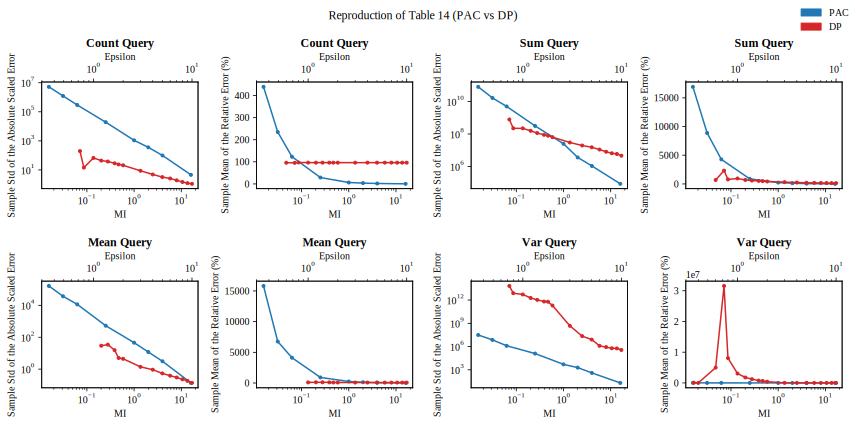

In [39]:
### An attempt at putting errors of both on the same axes, not aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    ax1b = ax1.twiny()
    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    ax1b.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax1b.set_xscale('log')
    ax1b.set_xlabel('Epsilon')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

    ax2b = ax2.twiny()
    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2b.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax2b.set_xscale('log')
    ax2b.set_xlabel('Epsilon')

    # align the scales
    # get range of x-axis for PAC
    ax1min, ax1max = ax1.get_xlim()
    ax1mineps, ax1maxeps = dp_ps_to_epsilon(calc_posterior(ax1min)), dp_ps_to_epsilon(calc_posterior(ax1max))
    ax1b.set_xlim(ax1mineps, ax1maxeps)

    ax2min, ax2max = ax2.get_xlim()
    ax2mineps, ax2maxeps = dp_ps_to_epsilon(calc_posterior(ax2min)), dp_ps_to_epsilon(calc_posterior(ax2max))
    ax2b.set_xlim(ax2mineps, ax2maxeps)



fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

### Plotting the error for comparison

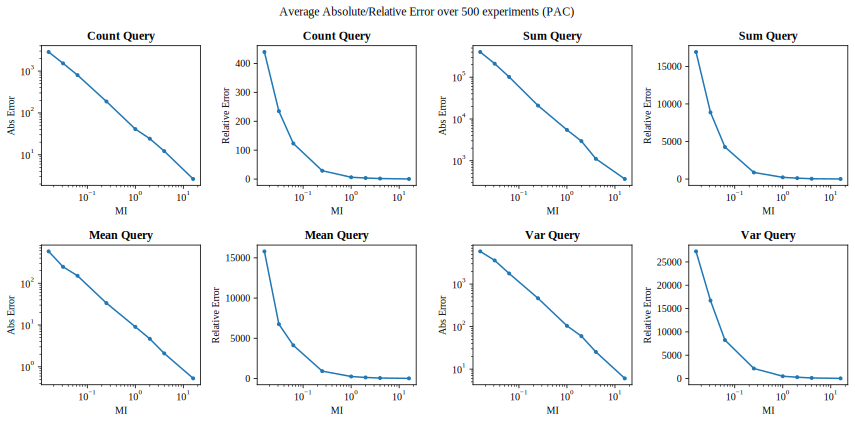

In [23]:
### Average Absolute/Relative error over 500 experiments (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

to_plot = pac_errors_df.pivot_table(index='mi', aggfunc='mean')  # create temporary df with aggregation to plot

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Absolute Scaled Error
    ax1.plot(to_plot.index, to_plot[f'absolute error {query}'], label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Abs Error')

    # Plotting Relative Error (%)
    ax2.plot(to_plot.index, to_plot[f'relative error {query}'], label=query, marker='.')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Relative Error')
    
del to_plot  # delete the temporary DataFrame

fig.suptitle("Average Absolute/Relative Error over 500 experiments (PAC)")
plt.tight_layout()
plt.show()

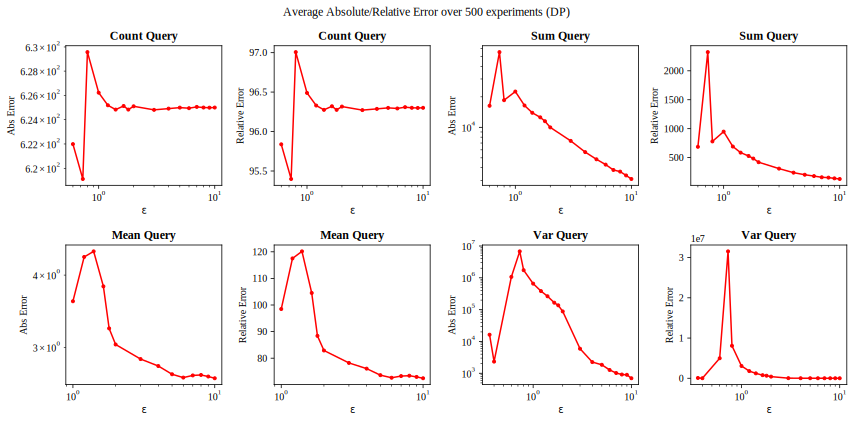

In [24]:
### Average Absolute/Relative error over 500 experiments (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

to_plot = dp_errors_df.pivot_table(index='eps', aggfunc='mean')  # create temporary df with aggregation to plot

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Absolute Scaled Error
    ax1.plot(to_plot.index, to_plot[f'absolute error {query}'], label=query, marker='.', color='red')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Abs Error')

    # Plotting Relative Error (%)
    ax2.plot(to_plot.index, to_plot[f'relative error {query}'], label=query, marker='.', color='red')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Relative Error')
    
del to_plot  # delete the temporary DataFrame

fig.suptitle("Average Absolute/Relative Error over 500 experiments (DP)")
plt.tight_layout()
plt.show()

In [25]:
# Used to convert dp.csv to dp-results.parquet; no longer needed
if False:
    with open('dp.csv', 'r') as f:
        dp_results = pd.read_csv(f)
    # rename headings
    mapping = {
        "Epsilon": "epsilon",
        "Average Absolute Error over 500 Samples - Count": "absolute error count",
        "Average Relative Error over 500 Samples - Count": "relative error count",
        "Average Absolute Error over 500 Samples - Sum": "absolute error sum",
        "Average Relative Error over 500 Samples - Sum": "relative error sum",
        "Average Absolute Error over 500 Samples - Mean": "absolute error mean",
        "Average Relative Error over 500 Samples - Mean": "relative error mean",
        "Average Absolute Error over 500 Samples - Var": "absolute error var",
        "Average Relative Error over 500 Samples - Var": "relative error var",
    }
    dp_results = dp_results.rename(columns=mapping)
    dp_results

# Additonal Extra Plotting

In [26]:
# get the 0th and 3rd columns of df
df.iloc[:, [0, 3]]
# filter to mi = 16
df.iloc[:, [0, 3]].where(df['mi'] == 16).dropna()

,mi,mean
0,16.0,2.511821
1,16.0,2.688667
2,16.0,3.206028
3,16.0,3.846939
4,16.0,3.275665
5,16.0,4.207085
6,16.0,3.828919
7,16.0,3.582506
8,16.0,3.192934
9,16.0,2.880819


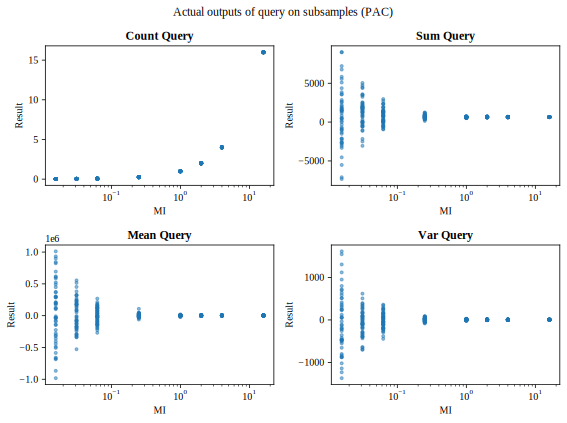

In [27]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = ['count', 'sum', 'mean', 'var']
# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'

    ax.scatter(df.iloc[:, 0], df.iloc[:, i], label=query, marker='.', alpha=0.5, color=PAC_COLOR)

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
        

    #d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    #ax.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
plt.show()

In [28]:
# dp_ps_to_epsilon(calc_posterior(mi)) -> epsilon
x = np.logspace(-8, 4, base=2, num=80)
y = [dp_ps_to_epsilon(calc_posterior(i)) for i in x] # eps
ps = [calc_posterior(i) for i in x] # posterior success

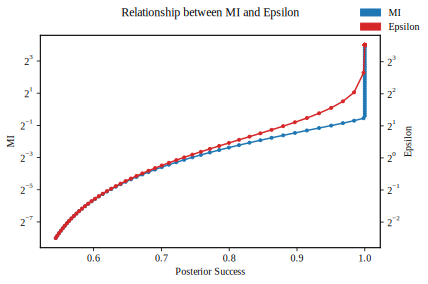

In [29]:
# Plot the relationship between MI and epsilon
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(ps, x, label='MI', color=PAC_COLOR, marker='.')
ax2 = ax.twinx()
ax2.plot(ps, y, label='Epsilon', color=DP_COLOR, marker='.')

ax.set_xlabel('Posterior Success')
ax.set_ylabel('MI')
ax2.set_ylabel('Epsilon')

ax.set_yscale('log', base=2)
ax2.set_yscale('log', base=2)

fig.suptitle("Relationship between MI and Epsilon")

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False, labels=['MI', 'Epsilon'])

plt.tight_layout()
plt.show()


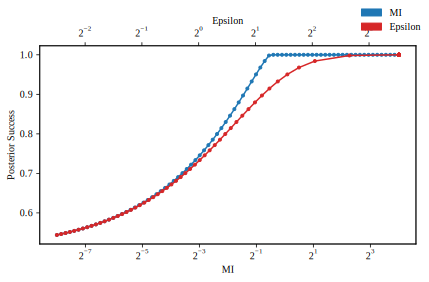

In [30]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, ps, color=PAC_COLOR, marker='.')
ax2 = ax.twiny()
ax2.plot(y, ps, color=DP_COLOR, marker='.')
ax.set_xlabel('MI')
ax.set_ylabel('Posterior Success')
ax2.set_xlabel('Epsilon')
ax.set_xscale('log', base=2)
ax2.set_xscale('log', base=2)
fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False, labels=['MI', 'Epsilon'])
plt.tight_layout()
plt.show()